In [1]:
import numpy as np
import scipy.stats
import scipy
import logging as logger

In [2]:
class JacksCarRentalEnvironment(object):

    MAX_CAPACITY = 20
    TRANSFER_COST = 2
    REQUEST_RATE = [3, 4]
    RETURN_RATE = [3, 2]
    RENTAL_INCOME = 10
    
    def __init(self):
        self = self.reset()

    def step(self, action):
        done = False
        reward = 0
        info = ''

        if(np.min(observation) <= 0):
            done = True
            info = 'No cars!'
        
        if(not done):
            cars_requested_1 = np.random.poisson(REQUEST_RATE[0])
            cars_requested_2 = np.random.poisson(REQUEST_RATE[1])
            observation[0] = observation[0] - cars_requested_1
            observation[1] = observation[1] - cars_requested_2

        if(np.min(observation) <= 0 and not done):
            done = True
            info = 'Not enought cars to fulfill requests!'

        if (not done):
            reward = (cars_requested_1 + cars_requested_2) * RENTAL_INCOME - (abs(action) * TRANSFER_COST)
        else:
            reward = -(abs(action) * 2)
            observation[0] = observation[0] - action
            observation[1] = observation[1] + action
        
        if(not done):
            if(observation[0] - action < 0 and observation[1] + action < 0):
                done = True
                info = 'Not enough cars to move!'
            else:
                observation[0] = observation[0] - action
                observation[1] = observation[1] + action

        cars_returned_1 = np.random.poisson(RETURN_RATE[0])
        cars_returned_2 = np.random.poisson(RETURN_RATE[1])
        observation[0] = observation[0] + cars_returned_1
        observation[1] = observation[1] + cars_returned_2
        np.clip(observation, None, MAX_CAPACITY)

        return observation, reward, False, info

    def reset(self, param=10):
        global observation
        observation = np.array([param, param])
        return observation

    @property
    def action_space(self):
        """
        Returns a Space object
        """
        raise NotImplementedError

    @property
    def observation_space(self):
        """
        Returns a Space object
        """
        raise NotImplementedError

In [3]:
class JacksCarRentalEnvironmentModel(JacksCarRentalEnvironment):
    
    def get_transition_probabilities_and_expected_reward(self, state, action):
        """
            Compute the $p(s', r\mid s,a)$
            Parameters
            ----------
            old_state: tuple of two ints
                the state (cars_at_A, cars_at_B)
            action: int
                nigthly movements of the cars as a int between -5 to 5, e.g.: 
                action +3: move three cars from A to B. 
                action -2: move two cars from B to A.
                
            Returns
            -------
            numpy array (2d - float): mapping from (new) states to probabilities
                index first dimension: cars at A
                index second dimension: cars at B
                value: probability  
            float:  expected reward for the state-action pair
        """
        #assert type(action) == int
        assert np.abs(action) <=5
        # first we move the cars in the night
        num_states_for_a_location = type(self).MAX_CAPACITY + 1
            
        state = self._nightly_moves(state, action)
    
        expected_reward = - type(self).TRANSFER_COST * np.abs(action)
        expected_reward += self._expected_reward_rent(state)
        
        transition_probabilities = self._rent_transition_probabilities(state)
        transition_probabilities = self._returns_transition_probabilities(transition_probabilities)
        return transition_probabilities, expected_reward  
        
        
    def _nightly_moves(self, state, action):
        
        cars_at_A = state[0]
        cars_at_B = state[1]
        if action > 0:
            cars_moved = min(action, cars_at_A)
        else:
            cars_moved = max(action, -cars_at_B)
        
        cars_at_A = min(cars_at_A - cars_moved, type(self).MAX_CAPACITY)
        cars_at_B = min(cars_at_B + cars_moved, type(self).MAX_CAPACITY)
        return [cars_at_A, cars_at_B]
        
    def _expected_reward_rent(self, state):
        expected_reward_rent = 0.
        m = type(self).MAX_CAPACITY+1
        request_mu = type(self).REQUEST_RATE
        for i in (0,1):
            cars_at_loc = state[i]
            rv = scipy.stats.poisson(request_mu[i])
            rent_prob = (rv.pmf(range(m)))
            logger.debug(rent_prob)
            rent_prob[cars_at_loc] = rent_prob[cars_at_loc:].sum()
            rent_prob[cars_at_loc+1:] = 0. 
            logger.debug(rent_prob)
            expected_reward_rent += np.dot(np.arange(len(rent_prob)), rent_prob) * type(self).RENTAL_INCOME
        return expected_reward_rent
        
    def _rent_transition_probabilities(self, state):
        
        num_states_for_a_location = type(self).MAX_CAPACITY + 1
        m = 15
        n = num_states_for_a_location + 2*m
        p_  = [np.zeros(n), np.zeros(n)]
        request_mu = type(self).REQUEST_RATE
        
        for i in (0,1):
            rv = scipy.stats.poisson(request_mu[i])
            cars_at_loc = state[i]
            x = cars_at_loc + m + 1     
            rent_prob = (rv.pmf(range(x)))
            assert state[i]-x+m+1 == 0
            p_[i][0:cars_at_loc+m+1] = rent_prob[::-1]
            p_[i][m] = p_[i][:m+1].sum()
            p_[i] = p_[i][m:-m]
        return p_
    
    def _returns_transition_probabilities(self, state_probalility):
        
        num_states_for_a_location = type(self).MAX_CAPACITY + 1
        m=11
        n = num_states_for_a_location + 2*m
        returns_mu = type(self).RETURN_RATE
        p_  = [np.zeros(num_states_for_a_location), np.zeros(num_states_for_a_location)]
        for i in (0,1):
            rv = scipy.stats.poisson(returns_mu[i])
            logger.debug(len(state_probalility[i]))
            for cars_at_loc in range(len(state_probalility[i])):
                p = np.zeros(n)
                logger.debug(p.shape)
                x = num_states_for_a_location - cars_at_loc + m - 1     
                return_prob = (rv.pmf(range(x)))
                logger.debug (p[cars_at_loc+m:-1].shape)
                p[cars_at_loc+m:-1] = return_prob
                logger.debug(return_prob)
                p[num_states_for_a_location+m-1] = p[num_states_for_a_location+m-1:].sum()
                p = p[m:-m]
                logger.debug(p)
                logger.debug(p.sum())
                p_[i] += p * state_probalility[i][cars_at_loc]
        return p_
    
    

In [4]:
def init_values_and_policy():
    values = np.ones((21, 21))
    policy = np.zeros((21, 21, 11))
    policy.fill(1/11)
    return values, policy

def update_values(state, values, policy, gamma=0.9):
    actions = np.arange(-5,5,1)
    # Summe (a | s)
    v_s = 0
    policy_for_state = policy[state[0],state[1]]
    for i in range(len(actions)):
        action = actions[i]
        policy_a_s = policy_for_state[i]
        probs, reward_a = model.get_transition_probabilities_and_expected_reward(state, action)
        # Summe (S' | a)
        # s_prime = S' (!)
        q_a_s_prime = 0
        for cars_a in range(len(probs[0])):
            for cars_b in range(len(probs[1])):
                prime_prob = probs[0][cars_a] * probs[1][cars_b]
                q_a_s_prime += prime_prob *values[cars_a, cars_b]
        v_s += policy_a_s * ( reward_a + gamma * q_a_s_prime )
    return v_s
    
def iterative_policy_evaluation_v(values, policy):
    new_values = np.zeros((21,21))
    for state_a in range(len(values)):
        for state_b in range(len(values[state_a])):
            state = (state_a, state_b)
            new_values[state_a,state_b] = update_values(state, values, policy)
    return new_values
    
def policy_evaluation(values, policy, max_updates=50, threshold=1.0):
    new_values = iterative_policy_evaluation_v(values, policy)
    run = 1
    while True:
        values = new_values
        new_values = iterative_policy_evaluation_v(values, policy)
        delta = np.max(np.abs(values - new_values))
        print('Update ' + str(run) + ' of max ' + str(max_updates) + ', delta = ' + str(delta))
        run += 1
        if delta < threshold:
            print('Updated value under threshold of ' + str(threshold))
            break
        if run >= max_updates:
            break
    return values
    
def policy_improvement():
    raise NotImplementedError

In [5]:
model = JacksCarRentalEnvironmentModel()
V,  policy = init_values_and_policy()
v_new = policy_evaluation(V, policy)

Update 1 of max 50, delta = 48.1432500783
Update 2 of max 50, delta = 38.6316120135
Update 3 of max 50, delta = 30.0980846745
Update 4 of max 50, delta = 23.1533863261
Update 5 of max 50, delta = 17.8459800903
Update 6 of max 50, delta = 13.8745679741
Update 7 of max 50, delta = 10.8969097466
Update 8 of max 50, delta = 8.63754863092
Update 9 of max 50, delta = 6.8982823777
Update 10 of max 50, delta = 5.54131487931
Update 11 of max 50, delta = 4.47077131092
Update 12 of max 50, delta = 3.6188001276
Update 13 of max 50, delta = 2.9362665744
Update 14 of max 50, delta = 2.38675150919
Update 15 of max 50, delta = 1.94269196862
Update 16 of max 50, delta = 1.58286107462
Update 17 of max 50, delta = 1.29068211983
Update 18 of max 50, delta = 1.05306869648
Update 19 of max 50, delta = 0.859603768639
Updated value under threshold of 1.0


In [25]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

def plot3d_over_states(f, zlabel="", ):
    MAX_CAPACITY = 20
    A = np.arange(0, MAX_CAPACITY+1)
    B = np.arange(0, MAX_CAPACITY+1)
    # B, A !!!
    B, A = np.meshgrid(B, A)
    V = f.reshape(MAX_CAPACITY+1,-1)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    #ax = fig.gca(projection='3d')
    #surf = ax.plot_surface(A, B, V, rstride=1, cstride=1, cmap=cm.coolwarm,
    #                   linewidth=0, antialiased=False)
    #fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.scatter(A, B, V, c='b', marker='.')
    ax.set_xlabel("cars at A")
    ax.set_ylabel("cars at B")
    ax.set_zlabel(zlabel)
 
    #ax.view_init(elev=10., azim=10)
    
    plt.show()

In [52]:
def plot_policy(policy):
    MAX_CAPACITY = 20
    A = np.arange(0, MAX_CAPACITY+1)
    B = np.arange(0, MAX_CAPACITY+1)
    # A, B = np.meshgrid(A, B)
    Po = policy.reshape(MAX_CAPACITY+1,-1)
    levels = range(-5,6,1)
    plt.figure(figsize=(7,6))
    CS = plt.contourf(A, B, Po)
    cbar = plt.colorbar(CS)
    cbar.ax.set_ylabel('actions')
    #plt.clabel(CS, inline=1, fontsize=10)
    plt.title('Policy')
    plt.xlabel("cars at B")
    plt.ylabel("cars at A")

/usr/lib/python3/dist-packages/mpl_toolkits/mplot3d/axes3d.py:120: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  self.axesPatch.set_linewidth(0)
/usr/lib/python3/dist-packages/mpl_toolkits/mplot3d/axes3d.py:2343: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  cstr = cbook.is_string_like(c) or cbook.is_sequence_of_strings(c)
/usr/lib/python3/dist-packages/mpl_toolkits/mplot3d/axes3d.py:247: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  self.axesPatch.draw(renderer)


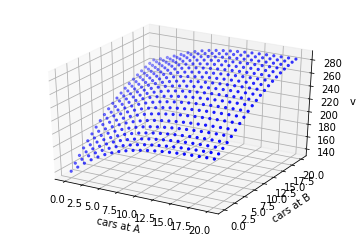

In [53]:
plot3d_over_states(v_new, 'v')

In [54]:
#plot_policy(policy)

ValueError: cannot reshape array of size 1 into shape (21,newaxis)

In [10]:
v_new_2 = policy_evaluation(v_new, policy)

Update 1 of max 50, delta = 0.701942982334
Updated value under threshold of 1.0


/usr/lib/python3/dist-packages/mpl_toolkits/mplot3d/axes3d.py:120: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  self.axesPatch.set_linewidth(0)
/usr/lib/python3/dist-packages/mpl_toolkits/mplot3d/axes3d.py:2343: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  cstr = cbook.is_string_like(c) or cbook.is_sequence_of_strings(c)
/usr/lib/python3/dist-packages/mpl_toolkits/mplot3d/axes3d.py:247: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  self.axesPatch.draw(renderer)


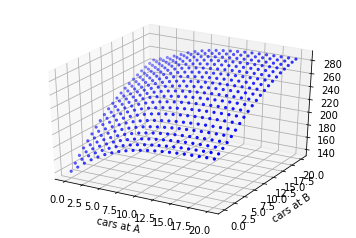

In [11]:
plot3d_over_states(v_new_2)

In [12]:
print(v_new_2.reshape(21,-1))

[[ 140.24309931  149.19391514  157.75786178  165.78575389  173.31876989
   180.52406141  187.59549358  194.12271749  200.13716662  205.6840664
   210.81683309  215.58627441  220.03165615  224.17877637  228.04344047
   231.63569612  234.96166107  238.02255971  240.81237589  243.31621191
   245.51183667]
 [ 149.17897172  157.68742889  165.60600107  172.98261997  179.99853011
   186.85688632  193.7228743   200.08286083  205.94636157  211.34557497
   216.33160613  220.95853062  225.26910687  229.29020586  233.03601215
   236.51297213  239.72237466  242.66002179  245.31486336  247.66947351
   249.15049635]
 [ 157.61699601  165.42624825  172.64647004  179.47299882  186.11827907
   192.75086335  199.48699228  205.72709974  211.47074242  216.74891423
   221.61628413  226.13070907  230.33649912  234.25952553  237.91111835
   241.29380844  244.4045381   247.23512404  249.77248035  251.58575911
   253.0533716 ]
 [ 165.24649543  172.31032011  178.94746752  185.37967181  191.77885239
   198.2633609